In [12]:
# Some imports to get us started
# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
import jupyterthemes as jt
from scipy.stats import truncnorm
# Generic ML imports
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

# EconML imports
from econml.ortho_iv import LinearIntentToTreatDRIV
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                    SingleTreePolicyInterpreter

%matplotlib inline
import matplotlib.pyplot as plt


In [14]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

### INTENT TO TREAT: NON-LINEAR AND LINEAR COMPLIANCE ###

##### Simulate EMM Data Set #####

In [15]:
# reproducibility
np.random.seed(1234)

# number of observations
size = 10000

# simulation parameters
avg_purchase_amt = 3.90
sd_avg_purchase_amt = 1.50
expected_num_purchases = 2.0
p_open = [0.7, 0.3]
p_click = [0.8, 0.2]
p_purchase = [0.85, 0.15]
cum_p_open = [0.55, 0.45]
cum_p_click = [0.52, 1-0.52]

### feature setup ###
# Customer-level categorical features #
age = np.random.choice(a=range(18,70), size=size)
gender = np.random.choice(a=range(2), size=size)
customer_segment = np.random.choice(a=range(6), size=size)

# Customer-level transactional features #
revenue_pre_7days = np.round(np.random.lognormal(avg_purchase_amt, sd_avg_purchase_amt, size), 2)
revenue_pre_14days = np.round(np.random.lognormal(avg_purchase_amt, sd_avg_purchase_amt, size), 2)
revenue_pre_21days = np.round(np.random.lognormal(avg_purchase_amt, sd_avg_purchase_amt, size), 2)
revenue_pre_28days = np.round(np.random.lognormal(avg_purchase_amt, sd_avg_purchase_amt, size), 2)

num_trx_pre_7days = np.random.poisson(expected_num_purchases, size)
num_trx_pre_14days = np.random.poisson(expected_num_purchases, size)
num_trx_pre_21days = np.random.poisson(expected_num_purchases, size)
num_trx_pre_28days = np.random.poisson(expected_num_purchases, size)

# Customer-level channel interaction features #
flag_open_28days = np.random.choice(a=range(2), p = cum_p_open, size=size)
flag_click_28days = np.random.choice(a=range(2), p = cum_p_click, size=size)
flag_click = np.random.choice(a=range(2), p = p_click, size=size)
flag_open = np.random.choice(a=range(2), p = p_open, size=size)
flag_purchase = np.random.choice(a=range(2), p = p_purchase, size=size)



In [16]:
mydict = {"age":age, "gender":gender, "cust_seg":customer_segment, 
          "rev_pre_7":revenue_pre_7days, "rev_pre_14":revenue_pre_14days,
          "rev_pre_21":revenue_pre_21days, "rev_pre_28":revenue_pre_28days,
          "trx_pre_7":num_trx_pre_7days, "trx_pre_14":num_trx_pre_14days,
          "trx_pre_21":num_trx_pre_21days, "trx_pre_28":num_trx_pre_28days,
          "flag_open_28days":flag_open_28days, "flag_click_28days":flag_click_28days, 
          "flag_click":flag_click, "flag_open":flag_open,
          "flag_purchase":flag_purchase}

df = pd.DataFrame(mydict,
                  columns=["age", "gender", "cust_seg", "rev_pre_7", "rev_pre_14",
                           "rev_pre_21", "rev_pre_28", "trx_pre_7", "trx_pre_14",
                           "trx_pre_21", "trx_pre_28", "flag_open_28days", "flag_click_28days",
                           "flag_click", "flag_open", "flag_purchase"])

##### Hardcode Business Rules and Purchase Logics into DataSet #####

In [17]:
for i, _ in df.iterrows():
    
    # IF trx_pre_28 == 0 then ALL transactional features MUST be 0 #
    if df.loc[i, 'trx_pre_28'] == 0:
        
        df.loc[i, 'rev_pre_7'] = 0
        df.loc[i, 'rev_pre_14'] = 0
        df.loc[i, 'rev_pre_21'] = 0
        df.loc[i, 'rev_pre_28'] = 0
        df.loc[i, 'trx_pre_7'] = 0
        df.loc[i, 'trx_pre_14'] = 0
        df.loc[i, 'trx_pre_21'] = 0
    
    # IF trx_pre_21 == 0 then ALL transactional features between 21 and 7 days MUST be 0#
    if df.loc[i, 'trx_pre_21'] == 0:
    
        df.loc[i, 'rev_pre_7'] = 0
        df.loc[i, 'rev_pre_14'] = 0
        df.loc[i, 'rev_pre_21'] = 0
        df.loc[i, 'trx_pre_7'] = 0
        df.loc[i, 'trx_pre_14'] = 0


        
    # IF trx_pre_14 == 0 then ALL transactional features between 14 and 7 days MUST be 0#
    if df.loc[i, 'trx_pre_14'] == 0:
        
        df.loc[i, 'rev_pre_7'] = 0
        df.loc[i, 'rev_pre_14'] = 0
        df.loc[i, 'trx_pre_7'] = 0

    # IF trx_pre_7 == 0 then ALL transactional features AT 7 days MUST be 0 #
    if df.loc[i, 'trx_pre_7'] == 0:
        df.loc[i, 'rev_pre_7'] = 0
    
    # IF click == 1 then open == 1 #
    if df.loc[i, 'flag_click'] == 1:
        df.loc[i, 'flag_open'] = 1
    
    # IF purchase == 1 then open & click ==1 #
    if df.loc[i, 'flag_purchase'] == 1:
        df.loc[i, 'flag_click'] = 1
        df.loc[i, 'flag_open'] = 1
        
    # IF open = 0 then click = 0#
    if df.loc[i, 'flag_open'] == 0:
        df.loc[i, 'flag_click'] = 0


##### Simulate Outcome of Interested (ie: Y using {X,Z,T,Y} notation #####

In [82]:
Y = lambda Y: ((Y['flag_purchase'] * ((truncnorm.rvs(0.1, 1, size=size) * Y['flag_click']) + (truncnorm.rvs(0.2, 1, size=size) * Y['flag_open']) +
                (0.75 * Y['rev_pre_7'] * truncnorm.rvs(0, 1, size=size)) + (0.1 * Y['rev_pre_14'] * truncnorm.rvs(0, 1, size=size))  
                + (0.15 * Y['rev_pre_21'] * truncnorm.rvs(0, 1, size=size)) + (0.02 * Y['rev_pre_28'] * truncnorm.rvs(0, 1, size=size)) 
                + 0.05 * Y['trx_pre_7'].apply(lambda x: sigmoid(x)) 
                + 0.1 * Y['trx_pre_14'].apply(lambda x: sigmoid(x)) 
                + 0.15 * Y['trx_pre_21'].apply(lambda x: sigmoid(x)) 
                + 0.2 * Y['trx_pre_28'].apply(lambda x: sigmoid(x))
               + Y['cust_seg'].apply(lambda x: sigmoid(x)) 
               - Y['age'].apply(lambda x: sigmoid(np.log1p(x))) 
               - Y['gender'] * truncnorm.rvs(0, 1, size=size) 
               + (Y['flag_open_28days'] * Y['flag_click_28days'])* truncnorm.rvs(0.1, 1, size=size)) 
               + truncnorm.rvs(0, 10, size=size)
              ))
df['Y'] = Y(df)

##### Define {X,Z,T,Y} #####

In [125]:
numeric_cols = ['rev_pre_7', 'rev_pre_14', 'rev_pre_21', 'rev_pre_28', 'trx_pre_7', 'trx_pre_14', 'trx_pre_21', 'trx_pre_28',
                'flag_open_28days', 'flag_click_28days']
cat_cols = ['age', 'gender']
seg_cols = ['seg_0', 'seg_1', 'seg_2', 'seg_3', 'seg_4', 'seg_5']
instrument = ['flag_open']
treatment = ['flag_purchase']
outcome = ['Y']

#### EDA & FEATURE ENGINEERING

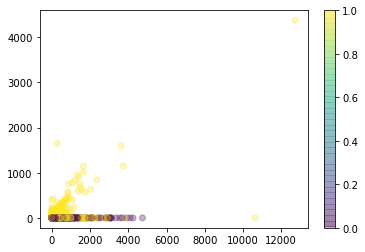

In [84]:
plt.scatter(df.rev_pre_7, df.Y, c=df.flag_open, alpha=0.3, cmap='viridis')
plt.colorbar();  # show color scale

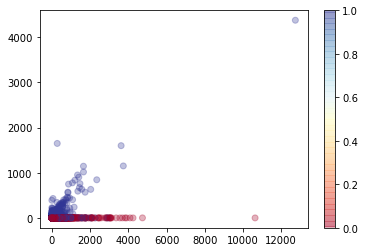

In [85]:
plt.scatter(df.rev_pre_7, df.Y, c=df.flag_click, alpha=0.3, cmap='RdYlBu')
plt.colorbar();  # show color scale

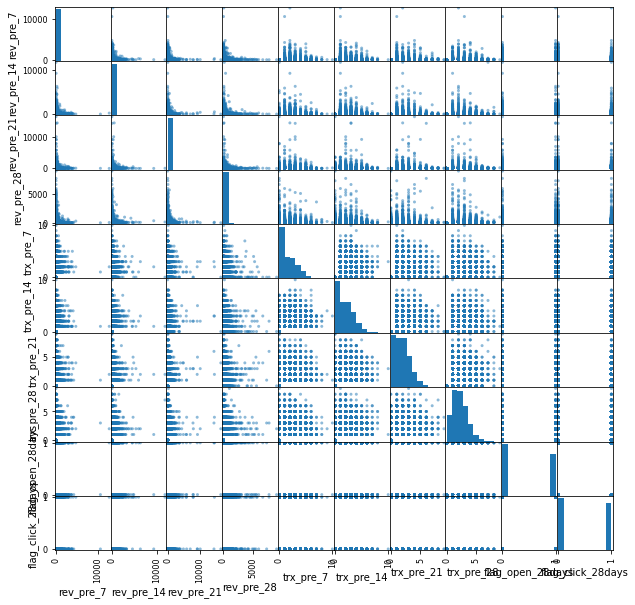

In [86]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[numeric_cols], figsize=(10, 10))
plt.show()

In [87]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_cols]))

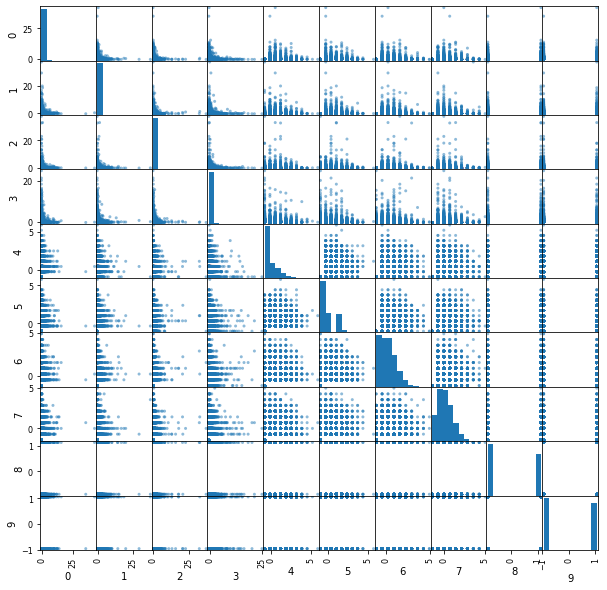

In [88]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_scaled, figsize=(10, 10))
plt.show()

##### Define Train/Test Split 

In [47]:
df_train = df.sample(frac = 0.9)

In [48]:
df_test=df.loc[~df.index.isin(df_train.index)]

In [102]:
X_train = np.concatenate((scaler.fit_transform(df_train[numeric_cols]),pd.get_dummies(df_train.cust_seg).values, df_train[['age', 'gender']].values), axis=1)
Z = df_train[instrument].values
T = df_train[treatment].values
Y_train = np.log1p(df_train[outcome]).values

In [103]:
X_test = np.concatenate((scaler.fit_transform(df_test[numeric_cols]),pd.get_dummies(df_test.cust_seg).values, df_test[['age', 'gender']].values), axis=1)
Y_test = np.log1p(df_test[outcome]).values

### Define treatment effect functional form (ie: not possible in a real-world data set)

In [118]:
# Define underlying treatment effect function 
TE_fn = lambda X: (1.2 + 1.1 * X['rev_pre_28'] + 0.7 * X['rev_pre_21'] + X['trx_pre_28'].apply(lambda x: sigmoid(x)) \
                  + X['trx_pre_21'].apply(lambda x: sigmoid(x)) \
                  - 0.7 * X['rev_pre_14'] - 1.5 * X['rev_pre_7'] - X['trx_pre_14'].apply(lambda x: sigmoid(x)) \
                  - 0.95 * X['trx_pre_7'].apply(lambda x: sigmoid(x)) \
                  + (X['seg_5'].apply(lambda x: sigmoid(x)) * (X['rev_pre_7'] + X['rev_pre_14']))).values

### Define nuisance models and final flexible model (ie: E(Y|X) & P(T|Z,X))

In [105]:
# Define nuissance estimators
lgb_T_XZ_params = {
    'objective' : 'binary',
    'boosting':'gbdt',
    'metric' : 'auc',
    'num_iterations' : 1000,
    'reg_alpha': 0.25,
    'reg_lambda': 0.75,
    'min_data_in_leaf':150,
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}

lgb_Y_X_params = {
    'metric' : 'rmse',
    'boosting':'dart',
    'num_iterations' : 5000,
    'reg_alpha': 0.25,
    'reg_lambda': 0.75,
    'min_data_in_leaf':150,
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}

lgb_flex_model_params = {
    'metric' : 'rmse',
    'boosting':'dart',
    'num_iterations' : 5000,
    'reg_alpha': 0.95,
    'reg_lambda': 0.95,
    'min_data_in_leaf':150,
    'learning_rate': 0.01,
    'num_leaves' : 30,
    'max_depth' : 5
}
model_T_XZ = lgb.LGBMClassifier(**lgb_T_XZ_params)
model_Y_X = lgb.LGBMRegressor(**lgb_Y_X_params)
flexible_model_effect = lgb.LGBMRegressor(**lgb_flex_model_params)

In [106]:
# Train EconML model
model = LinearIntentToTreatDRIV(
    model_Y_X = model_Y_X,
    model_T_XZ = model_T_XZ,
    flexible_model_effect = flexible_model_effect,
    featurizer = PolynomialFeatures(degree=1, include_bias=True),
    cov_clip = 0.001,
    n_splits = 5
)
model.fit(Y=Y_train, T=T, Z=Z, X=X_train, inference="statsmodels")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightg

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightg

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightg

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightg

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightg

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


C:\ProgramData\Anaconda3\lib\site-packages\econml\sklearn_extensions\linear_model.py:1695: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")


In [107]:
model.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
1,0.991,0.316,3.133,0.002,0.471,1.511
x0,1.047,0.296,3.541,0.0,0.56,1.533
x1,1.633,0.66,2.474,0.013,0.547,2.72
x2,0.836,0.357,2.341,0.019,0.249,1.423
x3,0.508,0.267,1.902,0.057,0.069,0.947
x4,0.262,0.353,0.742,0.458,-0.319,0.843
x5,-0.179,0.31,-0.579,0.563,-0.689,0.331
x6,0.664,0.281,2.365,0.018,0.202,1.125
x7,-0.087,0.288,-0.304,0.761,-0.561,0.386
x8,-0.36,0.243,-1.481,0.139,-0.761,0.04


In [131]:
test_customers = pd.DataFrame(X_test)
test_customers.columns = numeric_cols + seg_cols + cat_cols

In [133]:
true_customer_TE = TE_fn(test_customers)
model_customer_TE = model.effect(X_test)

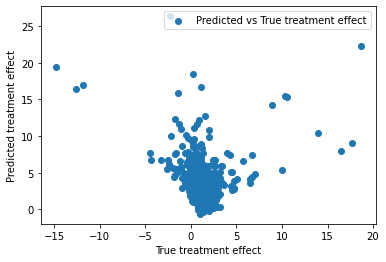

In [134]:
plt.scatter(true_customer_TE, model_customer_TE, label="Predicted vs True treatment effect")
plt.xlabel("True treatment effect")
plt.ylabel("Predicted treatment effect")
plt.legend()
plt.show()

#### Interpretation on a simpler Hypothesis Space 

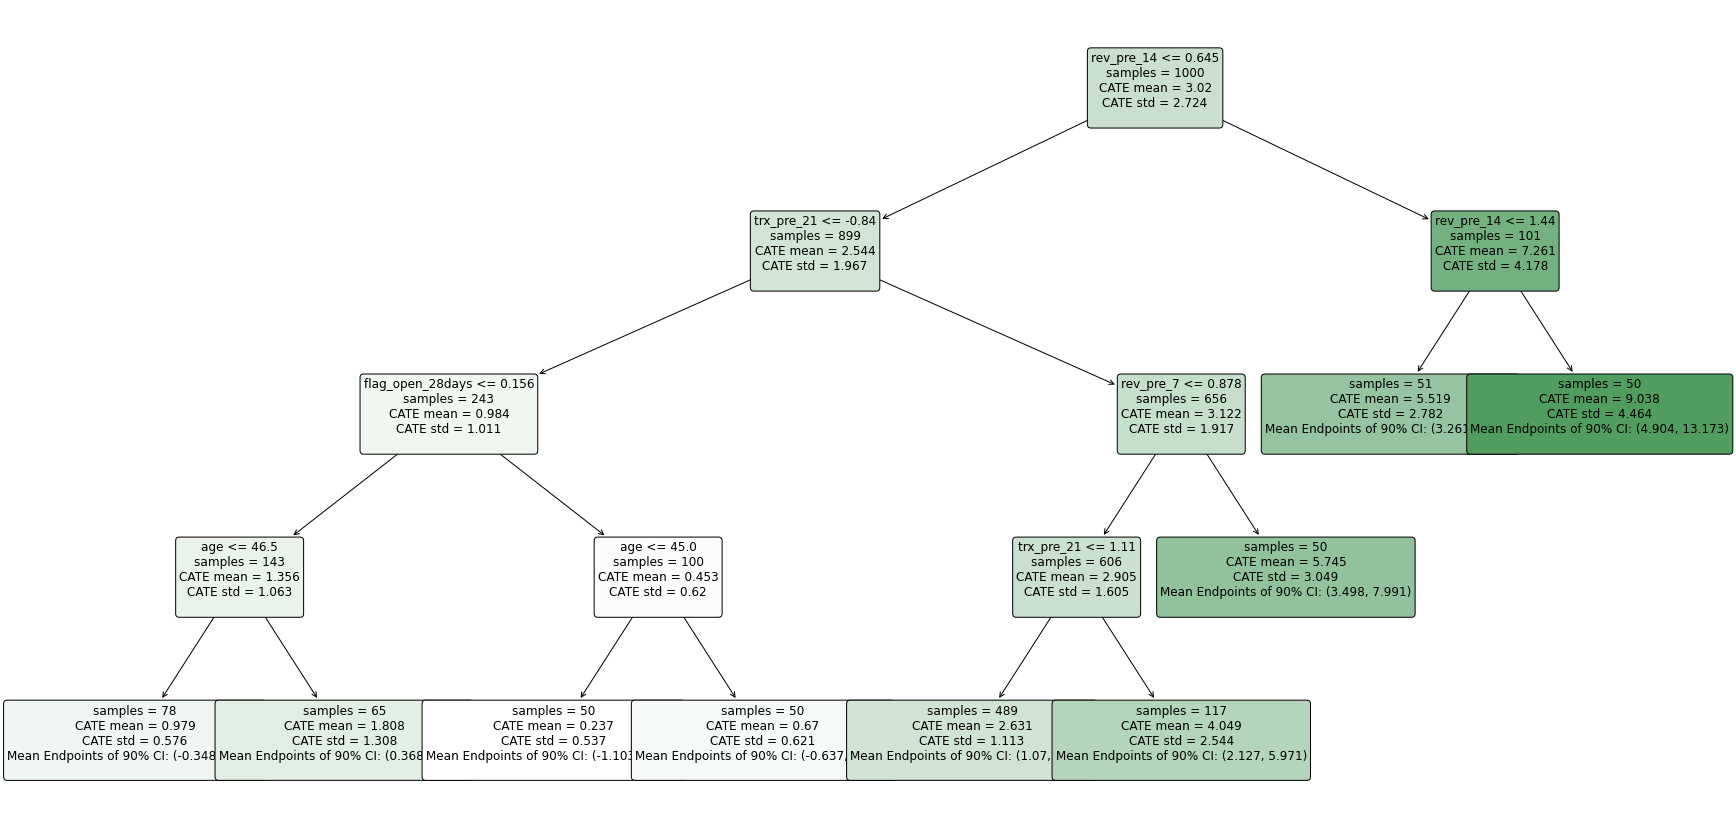

In [137]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=50)
intrp.interpret(model, X_test)
plt.figure(figsize=(30, 15))
intrp.plot(feature_names=test_customers.columns, fontsize=12)